In [1]:
import numpy as np
from os.path import dirname, join as pjoin

from scipy.misc import derivative
import sys,math
import scipy.io as sio
from scipy.io import readsav

import matplotlib.pyplot as plt 

from PIL import Image as im 

from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

from __future__ import print_function
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import copy

from skimage import data
from skimage.filters import unsharp_mask


In [2]:
font = {'family' : 'Times',
        'size'   : 30}	
plt.rc('font', **font) #set all plot font attributes according to above

In [3]:
def trackPercent(place,totalLength,strLen): #percent output tracker
    percent = place/totalLength*100
    if math.floor(percent)==69:
        string="{:.2f} % complete -- nice".format(percent)
    else:
        string="{:.2f} % complete".format(percent)
    sys.stdout.write("\r") #this "moves the cursor" to the beginning of the I0 line
    sys.stdout.write(" "*strLen) #this "clears" whatever was on the line last time by writing whitespace
    sys.stdout.write("\r") #move the cursor back to the start again
    sys.stdout.write(string) #display the current percent we are at
    sys.stdout.flush() #flush finishes call to print() (this is like what's under the hood of print function)
    strLen=len(string) #return the new string length for next function call
    return strLen

# 1-Parameter Models

## A family of curves to model the apparent kinematics of static streamer strucures in the corona as the PSP flies past them at perihelion 

------------------------------------------------------------------------------------------------------------------

### Fixed along-track distance (aka crossing time): 

### First, we just change the cross-track distance, i.e. the lateral distance from the spacecraft track / perpendicular-to-track distance

H_SW shape:  (20, 4200)   <--- 50 curves, each of [ ] data points equal to num in linspace


<ipython-input-4-1ffaa5247139>:23: RuntimeWarning: divide by zero encountered in true_divide
  alt_list.append(np.arctan((h_arr/x))*180./np.pi)


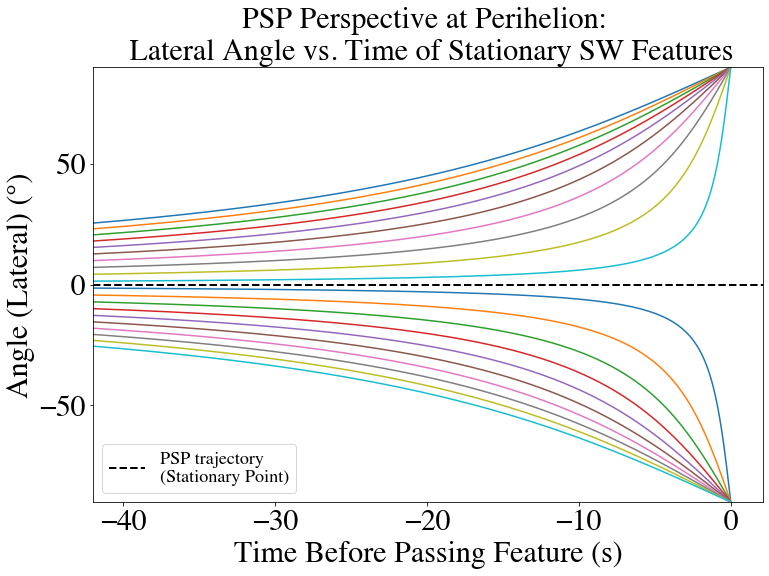

In [4]:
# Analytical Curves, with spacecraft speed set to unity and feature speeds fixed (zero speed)
    
# Number of curves we will examine
n = 20

# "Known" pysical quantities
v_PSP = 1 # km/s 
v_SW = 0 # km/s
x_0 = -42 # km

t_start = 42 # s
time_samples = 4200
H0_range = np.linspace(-20,20,num=n) # km
t = np.linspace(0,t_start,num=time_samples) # s

# Linear kinematic equations for SW features and s/c
H_SW = [H_0 +(v_SW*(t+t_start)) for H_0 in H0_range]
print("H_SW shape: ",(np.array(H_SW)).shape,"  <--- 50 curves, each of [ ] data points equal to num in linspace")
x = x_0 + (v_PSP*(t+t_start)) 
alt_list = []

for h_arr in H_SW:
    alt_list.append(np.arctan((h_arr/x))*180./np.pi)

plt.figure(figsize=(12,8))

for alt in alt_list:
    fig = plt.plot(-t,-alt,linestyle='solid') #,label='Apparent track of SW feature in FOV',color='blue') 

# Plot the results
plt.title("PSP Perspective at Perihelion: \n Lateral Angle vs. Time of Stationary SW Features",fontsize=30)
plt.xlabel("Time Before Passing Feature (s)",fontsize=30)
plt.ylabel("Angle (Lateral) (°)",fontsize=30)

plt.ylim(-90,90)
plt.xlim(-t_start)
plt.hlines(y=0,xmin=-t_start,xmax=10,color='black',linewidth=2,linestyle='--',label="PSP trajectory \n(Stationary Point)")
plt.legend(loc='lower left',fontsize=18)

The above graph shows the altitude of various (stationary) SW features at different lateral distances from the spacecraft track, as seen by PSP. These curves represent apparent motion of the features: It is PSP only that is moving.

No feature actually collides because no feature starts (and therefore stays) on the plane of orbit (as represented by the horizontal black line at altitude = 0 deg). All features eventually diverge from the FOV, but those closest to the spacecraft track show large changes in lateral angle, while those farther away from PSP present slower perspective changes.

### Fixed cross-track distance:

### Next, we vary along-track distances (aka crossing times)

<ipython-input-5-831f5890f876>:24: RuntimeWarning: divide by zero encountered in true_divide
  alt_list[curve] = (np.arctan((h0/cross_time_arr))*180./np.pi)
<ipython-input-5-831f5890f876>:24: RuntimeWarning: divide by zero encountered in true_divide
  alt_list[curve] = (np.arctan((h0/cross_time_arr))*180./np.pi)
<ipython-input-5-831f5890f876>:24: RuntimeWarning: divide by zero encountered in true_divide
  alt_list[curve] = (np.arctan((h0/cross_time_arr))*180./np.pi)
<ipython-input-5-831f5890f876>:24: RuntimeWarning: divide by zero encountered in true_divide
  alt_list[curve] = (np.arctan((h0/cross_time_arr))*180./np.pi)
<ipython-input-5-831f5890f876>:24: RuntimeWarning: divide by zero encountered in true_divide
  alt_list[curve] = (np.arctan((h0/cross_time_arr))*180./np.pi)
<ipython-input-5-831f5890f876>:24: RuntimeWarning: divide by zero encountered in true_divide
  alt_list[curve] = (np.arctan((h0/cross_time_arr))*180./np.pi)
<ipython-input-5-831f5890f876>:24: RuntimeWarning: divide 

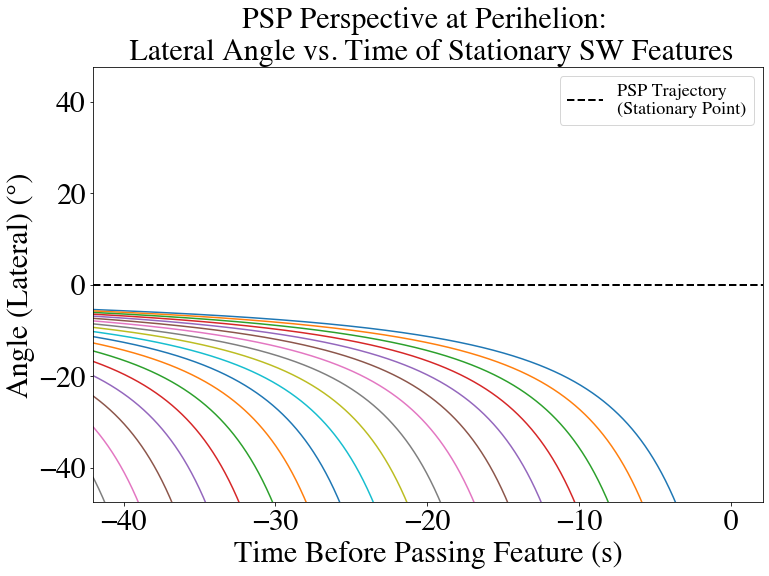

In [5]:
NCurves = 20
t_total = 42 # 42 time steps in coming synthetic data set

# "Known" pysical quantities
v_PSP = 1 # km/s 
v_SW = 0 # km/s
x_0 = -t_total # km

time_samples = 4200

h0 = 4

##
time_array = np.linspace(0,t_total,time_samples)
x_PSP = v_PSP*time_array

h0 = 4
cross_times = np.linspace(0,t_total,NCurves)
alt_list = np.zeros((len(cross_times),time_samples))

plt.figure(figsize=(12,8))
for curve in range(NCurves):
    cross_time_arr = time_array - cross_times[curve] # v_PSP = 1
    alt_list[curve] = (np.arctan((h0/cross_time_arr))*180./np.pi)
    alt_list_to_plot = alt_list[curve]
    alt_list_to_plot = alt_list_to_plot[time_array > cross_times[curve]]
    plt.plot(-t[time_array > cross_times[curve]],-alt_list_to_plot,linestyle='solid') 
    
    

# Plot the results
plt.title("PSP Perspective at Perihelion: \n Lateral Angle vs. Time of Stationary SW Features",fontsize=30)
plt.xlabel("Time Before Passing Feature (s)",fontsize=30)
plt.ylabel("Angle (Lateral) (°)",fontsize=30)
plt.ylim(-95/2., 95/2.)
plt.xlim(-t_total)
plt.hlines(y=0,xmin=-t_start,xmax=10,color='black',linewidth=2,linestyle='--',label="PSP Trajectory \n(Stationary Point)")
plt.legend(loc='upper right',fontsize=18)




# 2-Parameter Model:

## Arbitrary Collection of Curves (various cross-track distances and along-track distances)

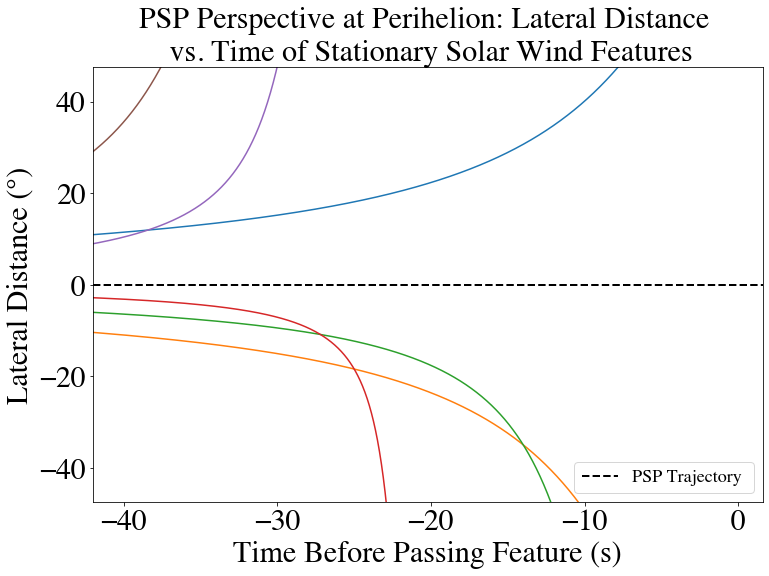

In [6]:
NCurves = 20

# "Known" pysical quantities
v_PSP = 1 # km/s 
v_SW = 0 # km/s
x_0 = -42 # km

t_total = 42 # s
time_samples = 4200

h0 = 4

##
time_array = np.linspace(0,t_total,time_samples)
x_PSP = v_PSP*time_array

cross_times = [0.5, 4,9,22,28,33,39,41]
heights = [-8,7,3.5,1,-2.2,-5,4,-3]
alt_list = np.zeros((len(cross_times),time_samples))

plt.figure(figsize=(12,8))
for height in range(len(heights)):
    cross_time_arr = time_array - cross_times[height] # v_PSP = 1
    alt_list[height] = (np.arctan((heights[height]/cross_time_arr))*180./np.pi)
    alt_list_to_plot = alt_list[height]
    alt_list_to_plot = alt_list_to_plot[time_array > cross_times[height]]
    plt.plot(-t[time_array > cross_times[height]],-alt_list_to_plot,linestyle='solid') 
    
    

# Plot the results
plt.title("PSP Perspective at Perihelion: Lateral Distance \n vs. Time of Stationary Solar Wind Features",fontsize=30)
plt.xlabel("Time Before Passing Feature (s)",fontsize=30)
plt.ylabel("Lateral Distance (°)",fontsize=30)
plt.ylim(-95/2.,95/2.)
plt.xlim(-t_start)
plt.hlines(y=0,xmin=-t_start,xmax=10,color='black',linewidth=2,linestyle='--',label="PSP Trajectory ")
plt.legend(loc='lower right',fontsize=18)


In [7]:
def imgcurves_2d_old(start_height, cross_time, LineWidth):
    '''Generate a 2-dimensional basis function in image space to cross-correlate with the J-Map curves'''
    
    
    ###---Dimensions in height and width of the image (in pixels)
    ImageYdim = 256 #h
    ImageXdim = 42 #w
    
    HalfLineWidth = LineWidth * 0.5
    YStrucOffsetParameter = 128
    t_total = 42
    
    
    h0 = start_height
    total_timesteps = 5000
        
    time_array = np.linspace(0,t_total,total_timesteps)
    x_PSP = v_PSP*time_array
    x0 = time_array - cross_time # v_PSP = 1
    h0 = start_height

    ### Compute the altitude/angle with the arctangent function (Do I need to use np.arctan2()???)
    altitude = (np.arctan((h0/(x0))))*180./np.pi

    
    ## Discern flat section of curve from steep section
    count_deriv = 0
    deriv_index = []
    
    for timestep in range(len(time_array)):
        #print(timestep)
        dydt = (altitude[timestep+1] - altitude[timestep])/(time_array[timestep+1] - time_array[timestep])
        if np.abs(dydt) > 0.2:
            deriv_index.append(timestep)
            count_deriv += 1
        if count_deriv == 1:
            break
    deriv_index = deriv_index[0]
    
    ## Determine where the crossing time occurs so that we can cut off the array at that value
    count = 0
    stop_index = []
    
    for timestep in range(len(time_array)):
        
        if time_array[timestep] > cross_time:
            stop_index.append(timestep)
            count += 1
        if count == 1:
            break
    
    stop_index = stop_index[0]
    #print("stopping index: ",stop_index)


    ActualXvalues = time_array
    ActualYvalues = altitude

    ###---Normalize X and Y values
    
    NormalizeX = time_array / np.max(time_array)
    NormalizeY = altitude / np.max(altitude)


    ###---Create pixel values (remember to start from 0!)
    PixelX = NormalizeX * (ImageXdim-1)
    PixelY = (NormalizeY * (0.5*ImageYdim -1) ) + YStrucOffsetParameter

    ###---Create a numpy array of 0s (framework for image)
    image_data_2d = np.full((ImageYdim, ImageXdim),0)

    ###---probably a vectorized way of doing this, rather than looping!
    iStep = 0
    xindices = []
    yindices = []
    
    
    #curve_central_data_points = np.zeros([ImageYdim,2])
    

    ### Draw the basic curve
    for x in PixelX:
        
        if iStep < (stop_index):
            xpos = PixelX[iStep] #x index - note these are made to integers below
            ypos = PixelY[iStep] #y index - note these are made to integers below
            jStep = 0
            xpos = xpos.astype(np.int)
            ypos = ypos.astype(np.int)
            
            
            for j in range(-LineWidth, LineWidth+1):
                
                yposPlot = ypos + j - int(HalfLineWidth)
                #yposPlotThin = ypos + round(j/2) - int(HalfLineWidth)
                
                xposPlot = xpos + j - int(HalfLineWidth)
                #xposPlotThin = xpos + round(j/2) - int(HalfLineWidth)
                
                
                ### The curve itself
                if yposPlot < ImageYdim and yposPlot >= 0 and xposPlot < ImageXdim and xposPlot >= 0: 
                    image_data_2d[(yposPlot),xposPlot] = 1
                    
                '''if yposPlot < ImageYdim and yposPlot >= 0: 
                    image_data_2d[(yposPlot),xpos] = 1
                    
                if xposPlot < ImageXdim and xposPlot >= 0: 
                    image_data_2d[(ypos),xposPlot] = 1'''
                
            
            
            iStep += 1
            
    diff_array = np.zeros([stop_index,2])
    
    # We want the width of the line/curve to be constant, but for large derivatives the y points get so spaced
    # out that the pre-determined line width doesn't connect the adjacent points. Solution: put a condition on 
    # the line width that hinges on distance between y points
    
    min_LineWidth = LineWidth 
    
    for pstep in range(stop_index-1):
#         diff_array[pstep,0] = PixelX[pstep+1] - PixelX[pstep]
#         diff_array[pstep,1] = PixelY[pstep+1] - PixelY[pstep]
        #derivative[pstep + 1] = diff_array[pstep,1] / diff_array[pstep,0]
        #print(image_data_2d[np.abs(derivative[pstep+1]) >= 10]) 
        
        # Fill in pixels above and below current pixel in a way that is sensitive to inter-point distances
        # i.e. line width varies to create continuous curve free of jaggies
        for j in range(-min_LineWidth, min_LineWidth+1):
            
            # First, compute the distance between the current y pixel and the former y pixel:
            y_val_diff = PixelY[pstep] - PixelY[pstep - 1]
            
            yposPlot = int(PixelY[pstep]) + j - int(HalfLineWidth) 
            
            
            # if the distance b/w adjacent y pixels > minimum linewidth, make the linewidth = ypixel distance:
            if np.abs(y_val_diff) > min_LineWidth:
                y_LineWidth = int(y_val_diff)
            else: 
                y_LineWidth = min_LineWidth
            
            # for each y point, create width in the x direction for all points above and below the current y 
            # pixel that abides by the necessary "width" in the y direction:

            for k in range(-y_LineWidth, y_LineWidth+1): 
                if k > j:
                    xposPlot == int(PixelX[pstep]) + k - int(HalfLineWidth) 
                else:
                    xposPlot = int(PixelX[pstep]) + k - int(HalfLineWidth) 
#                 xposPlot = int(PixelX[pstep]) + k - int(HalfLineWidth) 

                # to make sure we stay inside the image:
                
                if yposPlot < ImageYdim and yposPlot > 0 and xposPlot < ImageXdim and xposPlot >= 0:
                    if ( yposPlot - (yposPlot -1)) / (xposPlot - (xposPlot-1)) > 0.2:
                        image_data_2d[yposPlot,xposPlot] = 1
                    else:
                        image_data_2d[yposPlot,xposPlot] = 0
                    
                    
                    ## Supress horizontal component of the curve
#                     if pstep < deriv_index:
#                         image_data_2d[yposPlot,xposPlot] = 0.1  
          
    
            
    
    ### Negative band on either side of positive curve

    ysize,xsize = image_data_2d.shape
    
    for xstep in range(xsize-1):
        for ystep in range(ysize-1):

            if image_data_2d[ystep,xstep] == 1:
                if image_data_2d[ystep-1,xstep] == 0:
                    image_data_2d[ystep,xstep] = -1
                elif image_data_2d[ystep+1,xstep] == 0:
                    image_data_2d[ystep,xstep] = -1
                elif image_data_2d[ystep,xstep-1] == 0:
                    if not image_data_2d[ystep,0]:
                        image_data_2d[ystep,xstep] = -1
                elif image_data_2d[ystep,xstep+1] == 0:
                    image_data_2d[ystep,xstep] = -1
                                
    #print(image_data_2d[np.abs(np.tan(image_data_2d)) > 2])
    
    #image_data_norm = image_data_2d/np.sum(image_data_2d)
    
#     figure, ax = plt.subplots()
#     figure.set_size_inches(15, 15)
#     plt.imshow(image_data_2d/np.sum(image_data_2d), cmap='plasma',origin='lower',label='SW feature') #,extent=[0,140,-90,90])
    

#     #plt.plot(np.abs(np.tan(image_data_2d))+128)
#     plt.axhline(y=YStrucOffsetParameter,color='white',linestyle='--',label='Orbital Trajectory')
#     plt.legend(fontsize=18,loc='lower left')
#     plt.ylabel("Lateral Distance")
#     plt.xlabel("Time")
#     plt.title("Apparent Motion of a SW Feature Near PSP")



    #plt.title("Cross-track Distance: %0.1f v-timesteps\n Along-track distance: %0.0f v-timesteps"%(-start_height,cross_time),fontsize=30)
   
    return image_data_2d/np.sum(image_data_2d)

In [11]:
test = imgcurves_2d_old(.25, 30, 2)


# Load Synthetic Streamer Model and Make T-Maps:

### A T-Map is when you take a slice of latitude at a given/specified longitude for every image in the image cube and stack these slices of latitude in time

--------------------------------------------------
Date: Fri Apr 23 17:55:50 2021
User: pliewer_jpl
Host: pcliewer15mbp.charter.com
--------------------------------------------------
Format: 11
Architecture: x86_64
Operating System: darwin
IDL Version: 8.2.1
--------------------------------------------------
Successfully read 9 records of which:
 - 6 are of type VARIABLE
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - nsteps [<class 'numpy.int16'>]
 - nskip [<class 'numpy.int16'>]
 - jsteps [<class 'numpy.int16'>]
 - res [<class 'numpy.int16'>]
 - imgcube [<class 'numpy.ndarray'>]
 - rhocube [<class 'numpy.ndarray'>]
--------------------------------------------------
(42, 256, 512)
height of jmap:  256
width of jmap:  42


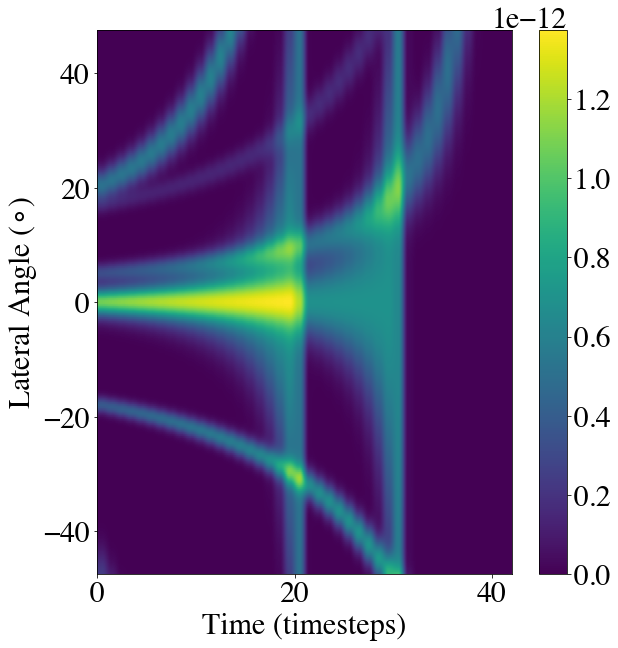

In [12]:
###### Render the jmap

dirname = '/Users/mkenny/Documents/PSP/StreamerModelMeganB/'
sav_fname = pjoin(dirname, 'cubestreamerspporbMeganB.sav')
sav_data = readsav(sav_fname,verbose='True')
imgcube = sav_data['imgcube']
print(imgcube.shape)

# T-map
lat_arr = imgcube[:,:,500] # For a given longitude (in the middle of the image)
tmap = np.transpose(lat_arr, (1,0))
print("height of jmap: ",tmap.shape[0])
print("width of jmap: ",tmap.shape[1])
timesteps_tmap = tmap.shape[1]

plt.figure(figsize=(10,10))
plt.imshow(tmap,origin='lower', aspect=0.58, extent=(0,timesteps_tmap,-95/2.,95/2.), cmap='viridis')

plt.ylabel('Lateral Angle ($\circ$)')
plt.xlabel('Time (timesteps)')
#plt.title('Lat-map for Static Streamer Model')
ax = plt.colorbar()



## Unsharp Mask the T-Map


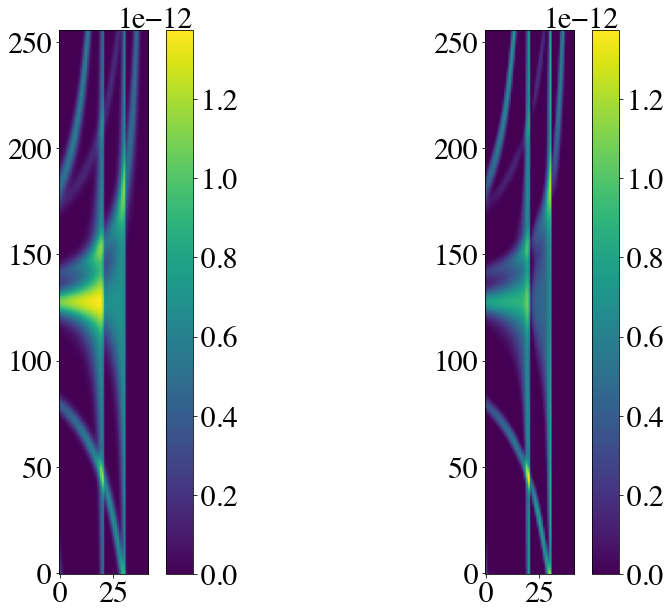

In [13]:
unsharp_masked_tmap = unsharp_mask(tmap, radius = 1.5, amount = 2)
norm_factor = np.max(tmap)/np.max(unsharp_masked_tmap)

plt.figure(figsize=(14,10))
plt.subplot(121)
plt.imshow(tmap,origin='lower',cmap='viridis')
plt.colorbar()

plt.subplot(122)
plt.imshow(unsharp_masked_tmap*norm_factor,origin='lower',cmap='viridis')
plt.colorbar()

## Load .txt file with PSP orbit and .sav file with streamer parameters (angular locations of footpoints)

In [14]:
filepath = '/Users/mkenny/Documents/PSP/StreamerModelMeganB/streamerspporb_MeganB.txt'
textfile = np.loadtxt(filepath, skiprows=15)


In [15]:
print(textfile.shape)
PSP_rsun = textfile[:,-1]
PSP_x_position = textfile[:,3]
PSP_y_position = textfile[:,4]
print(PSP_rsun, PSP_y_position)

(42, 6)
[12.0058 11.9747 11.9448 11.9161 11.8886 11.8623 11.8373 11.8135 11.791
 11.7697 11.7496 11.7308 11.7132 11.6969 11.6819 11.6681 11.6556 11.6443
 11.6343 11.6256 11.6182 11.612  11.6071 11.6035 11.6011 11.6001 11.6003
 11.6018 11.6045 11.6086 11.6139 11.6205 11.6284 11.6375 11.6479 11.6596
 11.6725 11.6867 11.7022 11.7189 11.7369 11.7561] [-4.49954   -4.32401   -4.14824   -3.97223   -3.79599   -3.61952
 -3.44285   -3.26597   -3.08891   -2.91166   -2.73425   -2.55667
 -2.37894   -2.20108   -2.02308   -1.84497   -1.66675   -1.48843
 -1.31002   -1.13153   -0.952976  -0.774367  -0.595712  -0.417022
 -0.238307  -0.0595777  0.119155   0.297881   0.476589   0.655268
  0.833909   1.0125     1.19103    1.3695     1.54788    1.72616
  1.90435    2.08243    2.26038    2.4382     2.61588    2.7934   ]


In [16]:
params_sav_file = '/Users/mkenny/Documents/PSP/StreamerModelMeganB/'
sav_fname = pjoin(params_sav_file, 'streamermodelMeganB.sav')
sav_data = readsav(sav_fname,verbose='True')
strand_params = sav_data['strandparams']
number_of_strands = sav_data['numstrands']
x_box_size = sav_data['boxsizex']
z_box_size = sav_data['boxsizez']

--------------------------------------------------
Date: Fri Apr 23 17:51:19 2021
User: pliewer_jpl
Host: pcliewer15mbp.charter.com
--------------------------------------------------
Format: 11
Architecture: x86_64
Operating System: darwin
IDL Version: 8.2.1
--------------------------------------------------
Successfully read 7 records of which:
 - 4 are of type VARIABLE
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - numstrands [<class 'numpy.int16'>]
 - boxsizex [<class 'numpy.float32'>]
 - boxsizez [<class 'numpy.float32'>]
 - strandparams [<class 'numpy.ndarray'>]
--------------------------------------------------


In [17]:
print("Number of strands: ",number_of_strands)
print("x, z box sizes: %f, %f"%(x_box_size,z_box_size))

stxarr = strand_params[2:9]
stzarr = strand_params[9:16]
maxden = strand_params[23:30]

print("\nx angle (on solar surface): ",stxarr)

print("\nz angle (on solar surface): ",stzarr)

print(strand_params[23:30])

Number of strands:  7
x, z box sizes: 0.600000, 0.200000

x angle (on solar surface):  [1.4922565 1.6493361 1.3437458 1.7915735 1.6255139 1.3524284 1.288579 ]

z angle (on solar surface):  [1.5707964 1.5707964 1.4913814 1.6381266 1.5165703 1.5469663 1.6619055]
[9000000.  9000000.  2329154.  3544458.  8139651.5 6517850.5 9705017. ]


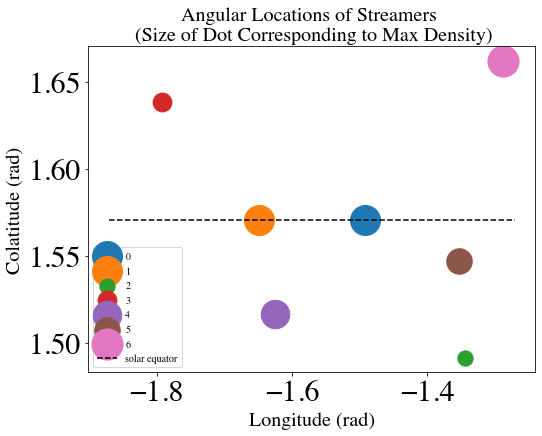

In [44]:
plt.figure(figsize=(8,6))
for i in range(7):
    plt.scatter(x=-stxarr[i], y=stzarr[i], s=1e-4*maxden[i],label=str(i))
styarr = np.zeros(7)
plt.hlines(y=np.pi/2.,xmin=-np.pi/2.-0.3, xmax=-np.pi/2+0.3,color='black',ls='--',label='solar equator')
# plt.scatter(np.pi/2, np.pi/2, marker='*',color='black',label='Box Center')
plt.ylabel('Colatitude (rad)',fontsize='20'), plt.xlabel('Longitude (rad)',fontsize='20')
plt.title('Angular Locations of Streamers \n (Size of Dot Corresponding to Max Density)',fontsize='20')
plt.legend(fontsize='10',loc='lower left')

In [19]:
# (lon, lat) to (x, y, z)
streamer_longitudes = stxarr; streamer_colatitudes = stzarr
x_cartesian = np.zeros((7,42)); y_cartesian = np.zeros((7,42)); z_cartesian = np.zeros((7,42))
x_diff = np.zeros((7,42)); y_diff = np.zeros((7,42))

for st_idx in range(7):
    for timestep_idx in range(len(PSP_rsun)):
        x_cartesian[st_idx, timestep_idx] = PSP_rsun[timestep_idx] * np.cos(streamer_colatitudes[st_idx] - np.pi/2.) * np.cos(streamer_longitudes[st_idx]  - np.pi/2.)
        y_cartesian[st_idx, timestep_idx] = PSP_rsun[timestep_idx] * np.cos(streamer_colatitudes[st_idx] - np.pi/2.) * np.sin(streamer_longitudes[st_idx]  - np.pi/2.)
        z_cartesian[st_idx, timestep_idx] = PSP_rsun[timestep_idx] * np.sin(streamer_colatitudes[st_idx] - np.pi/2.)
        if (PSP_y_position[timestep_idx] - y_cartesian[st_idx, timestep_idx] ) > 0:
            x_diff[st_idx, timestep_idx] = PSP_x_position[timestep_idx] - x_cartesian[st_idx, timestep_idx]
            y_diff[st_idx, timestep_idx] = PSP_y_position[timestep_idx] - y_cartesian[st_idx, timestep_idx]
        

Text(0.5, 0, 'y (from PSP)')

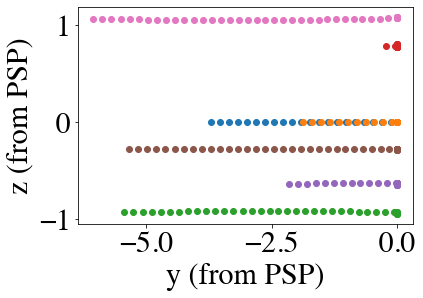

In [20]:
import scipy.interpolate as spi

for i in range(7):
    plt.scatter(-y_diff[i], z_cartesian[i],marker='o')
    
plt.ylabel("z (from PSP)")
plt.xlabel("y (from PSP)")

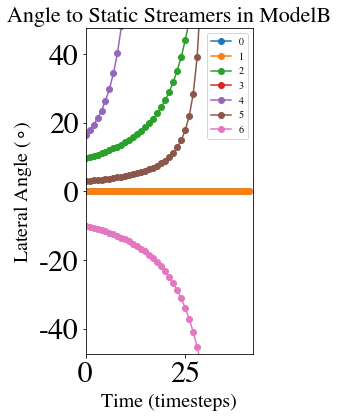

In [21]:
idx = np.zeros(7)
fig, ax = plt.subplots(figsize=(3,6))
for i in range(7):

    angle = np.arctan(-z_cartesian[i]/(0.01 + y_diff[i]))

    ax.plot(180.*np.flip(angle)/np.pi, label=str(i),marker='o')
    
ax.legend(fontsize=10)
plt.ylim(-95/2,95/2)
plt.xlim(0,42)
plt.title("Angle to Static Streamers in ModelB",fontsize='22')
plt.ylabel("Lateral Angle ($\circ$)",fontsize='20'), plt.xlabel("Time (timesteps)",fontsize='20')
ax.yaxis.grid(True, which='minor')
ax.yaxis.set_major_formatter('{x:.0f}')

## Make the Tomogram


In [45]:
'''
Here I compute the inner product of the image (of the analytic curve) and the tmap and fill each pixel
of the output image- the tomogram- with the inner product that corresponds to the the unique parameter pair
''' 

x0_param = np.linspace(2,timesteps_tmap,num=80) # along track distance (start at 0.1 to avoid dividing by zero)
# h0_param = np.linspace(-22,22,num=120)
h0_param_neg = np.linspace(-25,-0.5, num=70)
h0_param_pos = np.linspace(0.5,25, num=70) # cross-track distance
h0_param = np.concatenate((h0_param_neg,h0_param_pos))

tomogram_array = np.zeros((len(h0_param),len(x0_param)))
selected_angular_span = 95
tmap = unsharp_masked_tmap

str_len = 0
for x in range(len(x0_param)-1):
    for y in range(len(h0_param)-1):
        #print(x,y,x0_param[x],h0_param[y])
        # reset sum each each we eval a new combination of x0, h0
        x0_h0_pixel_sum = 0 
        
        # make an output image (the tomogram) to fill
           # This output image doesn't have to be the same size as the tmap and image curve
              # The sizes of the parameter arrays determine the size of the tomogram
                        
        #  
        '''epsilon = 0.001 # define epsilon
        GS_vector = GS_orthogalization(h0_param[y], x0_param[x], epsilon) # call function to tweak original BF
'''
        image_curve_2d = imgcurves_2d_old(h0_param[y], x0_param[x],2)
        
        img_tmap_product = tmap*image_curve_2d
        x0_h0_pixel_sum = np.sum(img_tmap_product)
        
        
        # Once done looping through pixels in tmap and image curve image, fill the tomogram pixel w/ porduct-integral
        #print(type(running_sum))
        
        #print("x, y, x0[x], h0[y],running sum: ",x,y,x,h0_param[y],x0_h0_pixel_sum)
        
        tomogram_array[y,x] = x0_h0_pixel_sum
        
        str_len = trackPercent(x,len(x0_param),str_len)
      

0.00 % complete

<ipython-input-7-a55e60f619b3>:209: RuntimeWarning: divide by zero encountered in true_divide
  return image_data_2d/np.sum(image_data_2d)
<ipython-input-7-a55e60f619b3>:209: RuntimeWarning: invalid value encountered in true_divide
  return image_data_2d/np.sum(image_data_2d)
<ipython-input-45-2b86134f7b7c>:33: RuntimeWarning: invalid value encountered in multiply
  img_tmap_product = tmap*image_curve_2d


97.50 % complete

(140, 80)


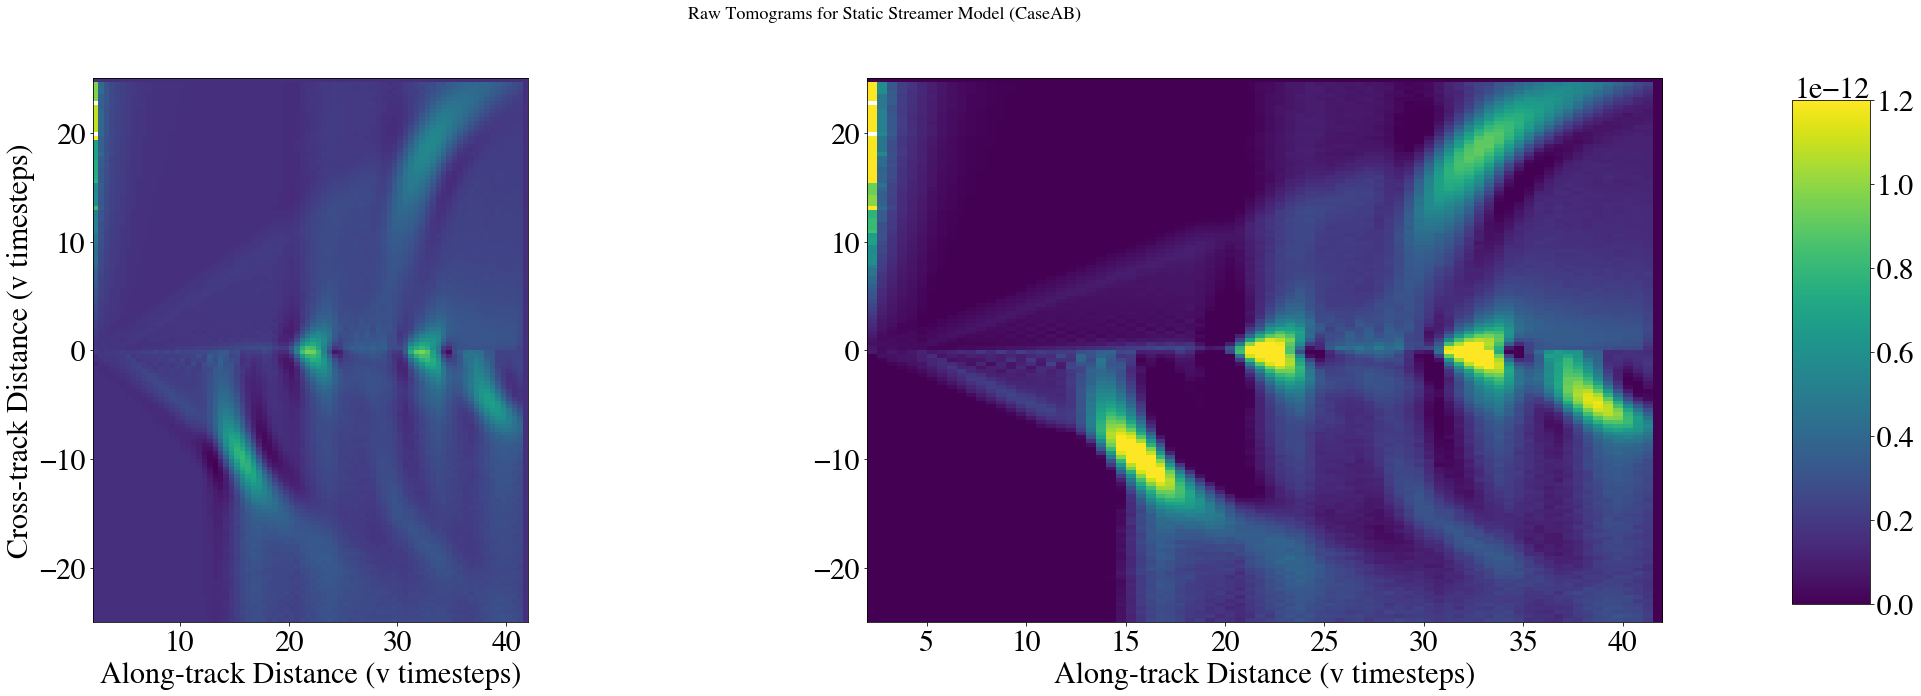

In [46]:
print(tomogram_array.shape)
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(36,10))
ax1.imshow(tomogram_array,origin='lower',extent=(2,tmap.shape[1],h0_param[0],h0_param[-1],),cmap='viridis')
zoomed_in = ax2.imshow(tomogram_array,origin='lower',aspect='auto',extent=(2,tmap.shape[1],h0_param[0],h0_param[-1],),cmap='viridis',vmin=0,vmax=1.2e-12)


ax1.set_xlabel('Along-track Distance (v timesteps)')
ax2.set_xlabel('Along-track Distance (v timesteps)')

ax1.set_ylabel('Cross-track Distance (v timesteps)')
fig.suptitle('Raw Tomograms for Static Streamer Model (CaseAB)',fontsize=18)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(zoomed_in,cax=cbar_ax)



## Basis curves line width = 2 :

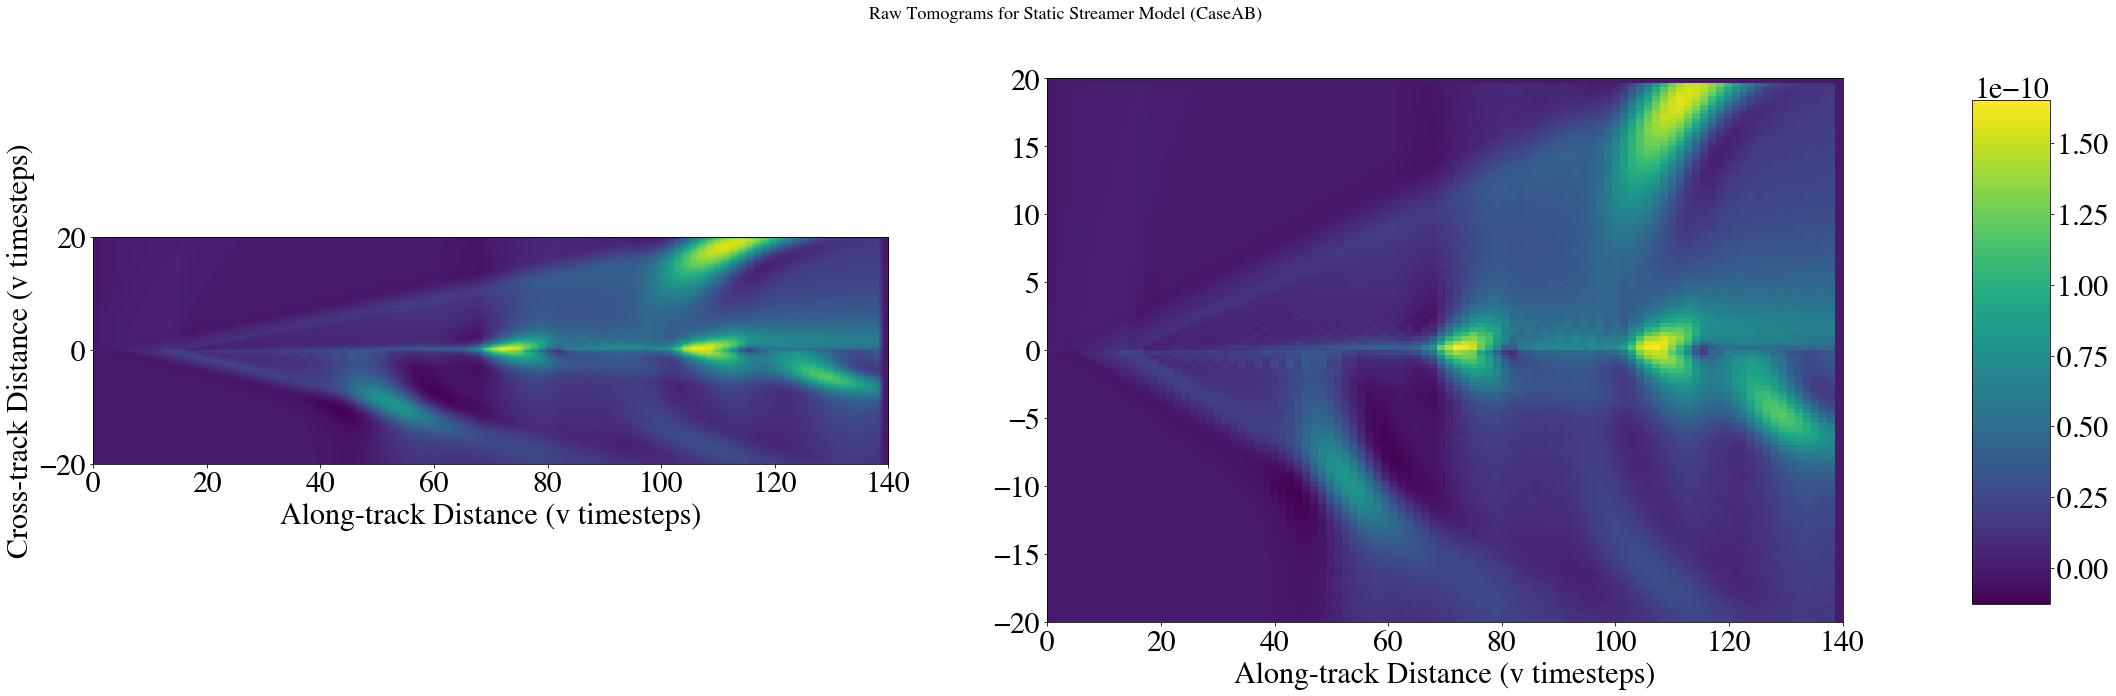


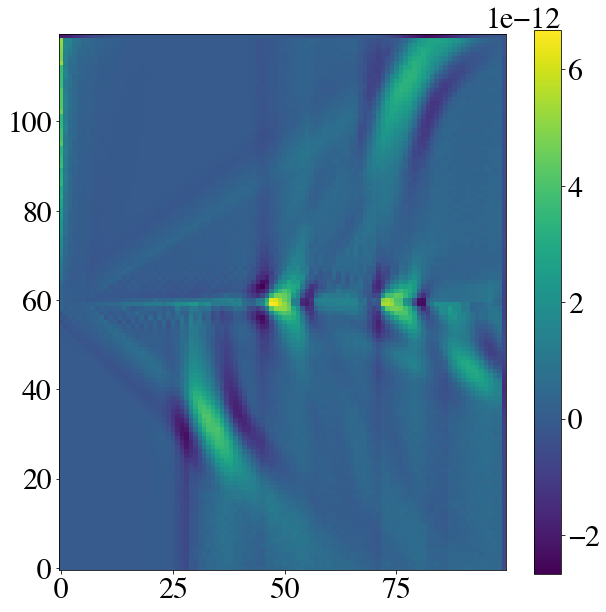

In [412]:
from skimage.filters import unsharp_mask
unsharp_masked_tomogram = unsharp_mask(tomogram_array, radius = 3, amount = 2)
plt.figure(figsize=(10,10))
plt.imshow(unsharp_masked_tomogram, cmap='viridis',origin='lower',vmin=)
plt.colorbar()

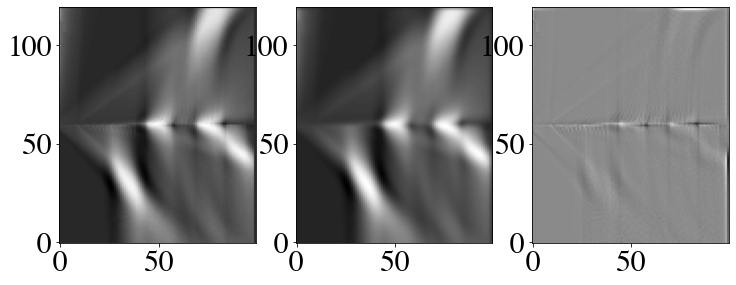

In [58]:
import scipy
from scipy import misc
from scipy.ndimage import gaussian_filter

fig, (ax1, ax2 ,ax3) = plt.subplots(1, 3,figsize=(12,8))
plt.gray()
ax1.imshow((tomogram_array), origin='lower')

gaussian_kernel = gaussian_filter(tomogram_array, sigma=1)
ax2.imshow(gaussian_kernel, origin='lower')

kernel_subtracted = tomogram_array - gaussian_kernel
ax3.imshow(kernel_subtracted, origin='lower')